# Exercise 2: Document-level embedding analysis of PubMed papers with SPECTER

In [1]:
from transformers import AutoTokenizer, AutoModel

# Load SPECTER model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("allenai/specter")
model = AutoModel.from_pretrained("allenai/specter")

/Users/kevin/.pyenv/versions/3.11.6/envs/cbb634-pytorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load dictionary of papers 
import json

with open("papers_dict.json") as f:
    papers = json.load(f)

In [3]:
# Process papers to find SPECTER embeddings
from tqdm import tqdm

# Convert papers dictionary into embeddings dictionary
embeddings = {}
for pmid, paper in tqdm(papers.items()):
    data = [paper["ArticleTitle"] + tokenizer.sep_token + paper["AbstractText"]]
    inputs = tokenizer(
        data, padding=True, truncation=True, return_tensors="pt", max_length=512
    )
    result = model(**inputs)
    # Take the first token in the batch as the embedding
    embeddings[pmid] = result.last_hidden_state[:, 0, :].detach().numpy()[0]

# Turn the dictionary into a list
embeddings = [embeddings[pmid] for pmid in papers.keys()]

100%|██████████| 1997/1997 [03:10<00:00, 10.50it/s]


In [4]:
# Identify the first three principal components of the paper embeddings
from sklearn import decomposition
import pandas as pd

pca = decomposition.PCA(n_components=3)
embeddings_pca = pd.DataFrame(
    pca.fit_transform(embeddings),
    columns=['PC0', 'PC1', 'PC2']
)
embeddings_pca["query"] = [paper["query"] for paper in papers.values()]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


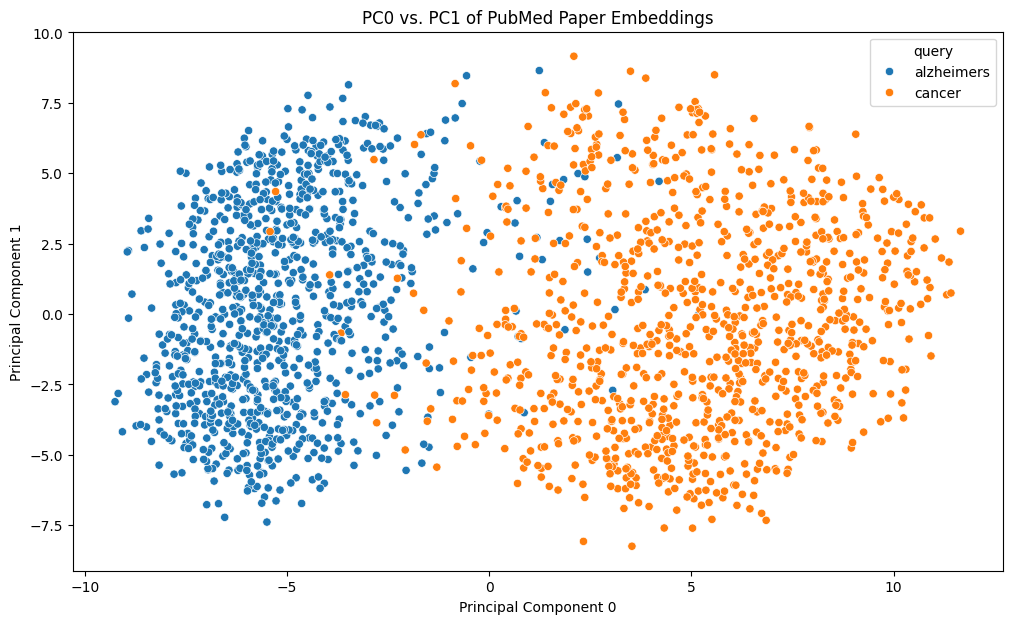

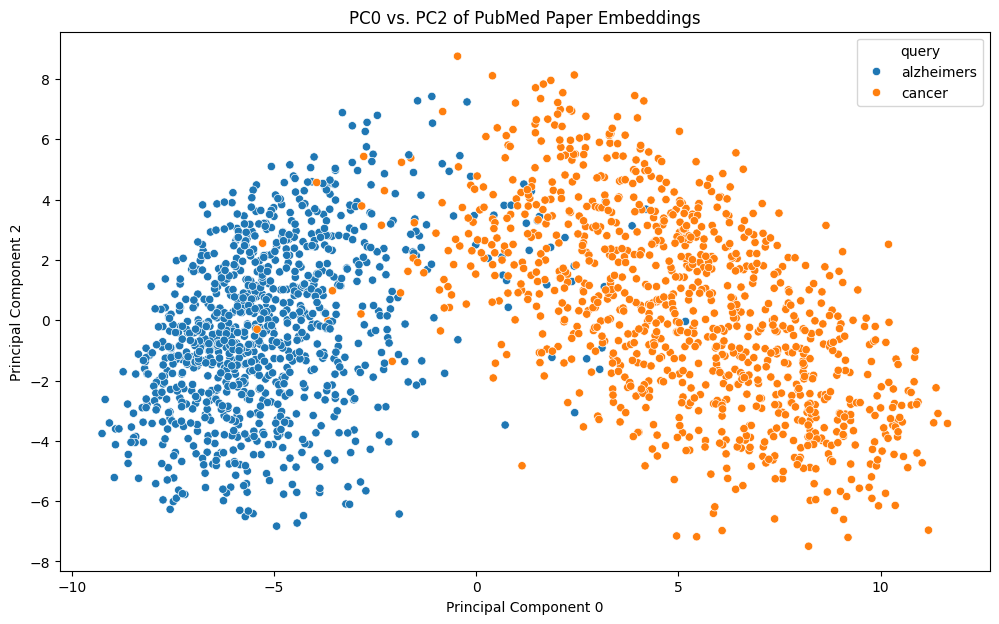

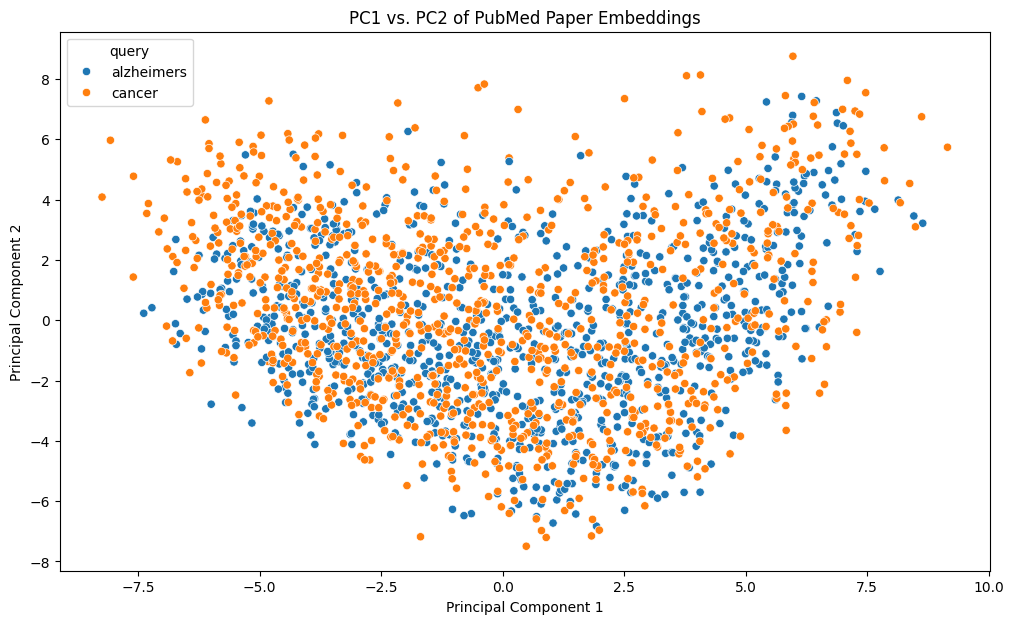

In [13]:
# Plot 2-D scatter plots for PC0 vs PC1, PC0 vs PC2, PC1 vs PC2, color-coded by search query
import seaborn as sns
import matplotlib.pyplot as plt

# PC0 vs PC1
plt.figure(figsize=(12,7))
sns.scatterplot(data = embeddings_pca, x = "PC0", y = "PC1", hue = "query")
plt.title("PC0 vs. PC1 of PubMed Paper Embeddings")
plt.xlabel("Principal Component 0")
plt.ylabel("Principal Component 1")
plt.show()

# PC0 vs PC2
plt.figure(figsize=(12,7))
sns.scatterplot(data = embeddings_pca, x = "PC0", y = "PC2", hue = "query")
plt.title("PC0 vs. PC2 of PubMed Paper Embeddings")
plt.xlabel("Principal Component 0")
plt.ylabel("Principal Component 2")
plt.show()

# PC1 vs PC2
plt.figure(figsize=(12,7))
sns.scatterplot(data = embeddings_pca, x = "PC1", y = "PC2", hue = "query")
plt.title("PC1 vs. PC2 of PubMed Paper Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

**Interpretation:** The plots for PC0 vs. PC1 and PC0 vs. PC2 show distinct separation of the papers. This suggests that the most significant variance in the data, that is, what really distinguished Alzheimer's papers from cancer papers (e.g. specialized terminology for each field) was captured by PC0. This means that PC0 accounted for a high proportion of the total variance in the dataset. On the other hand, the plot for PC1 vs. PC2 shows almost no separation of papers; rather, the clusters are almost entirely laid on top of each other. This suggests that PC1 and PC2 capture variance that didn't really set the two clusters of papers apart (e.g. a consistent academic-sounding writing style, research common to both fields), accounting for a lesser proportion of the total variance in the dataset.